# End-to-End Dog Breed Classification

In [7]:
# !unzip "drive/MyDrive/Dog-Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog-Vision"

## Getting our workspace ready

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
print('TF version ', tf.__version__)
print('hub version ', hub.__version__)
print('GPU availabe' if tf.config.list_physical_devices("GPU") else "not available")

TF version  2.5.0
hub version  0.12.0
GPU availabe


## Getting our data ready (Turning images into Tensors)

In [9]:
# Checking out labels of data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog-Vision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     6e80238fe40085f699fb15bb57cac132  scottish_deerhound
freq                                   1                 126


In [10]:
print(labels_csv.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


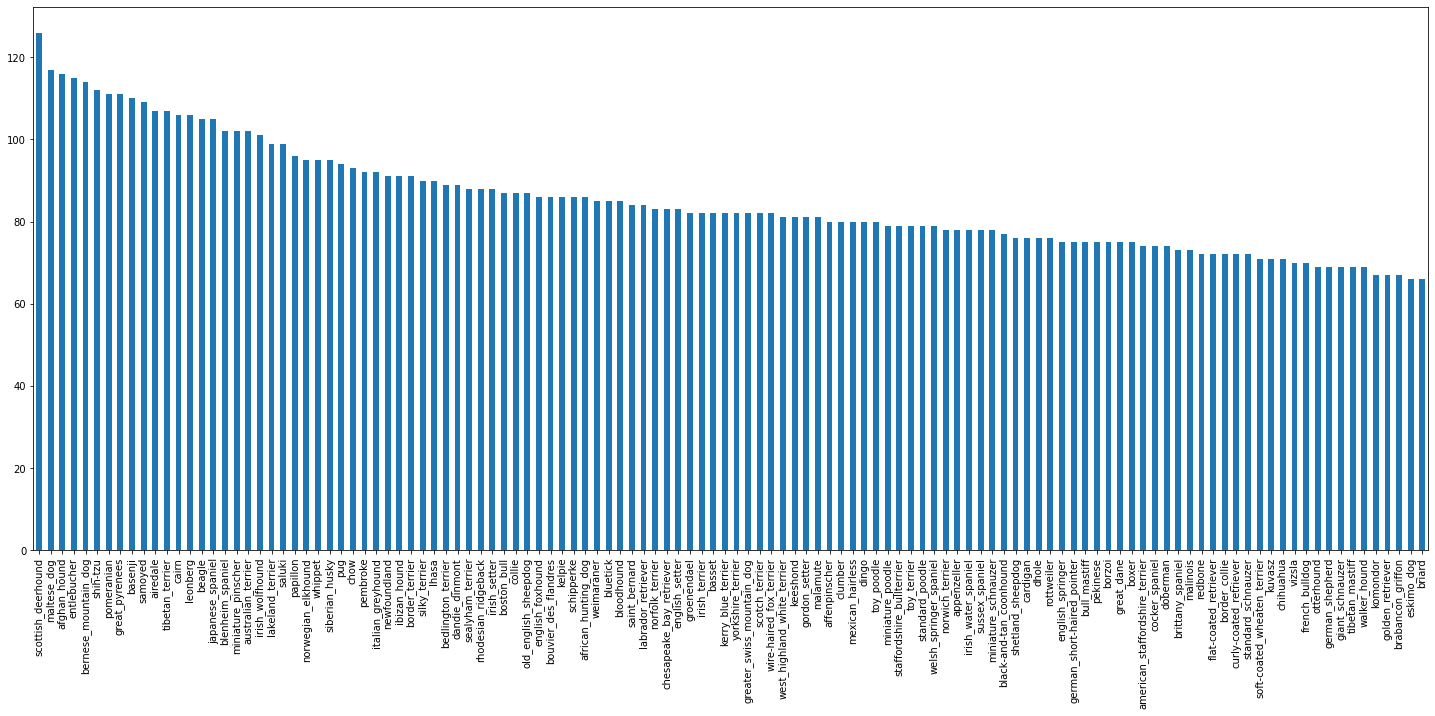

In [11]:
# How many images of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(25,10))

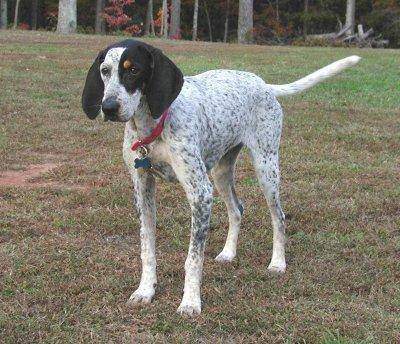

In [12]:
from IPython.display import display, Image
Image("/content/drive/MyDrive/Dog-Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")
 

### Getting Images and their labels

Lets create a list of all our image pathnames

In [13]:
filenames = [ "/content/drive/MyDrive/Dog-Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['/content/drive/MyDrive/Dog-Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog-Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [14]:
import os                                      # Checking if filenames are equal to original data
if len(os.listdir("drive/MyDrive/Dog-Vision/train")) == len(filenames):
  print("Proceed")

Proceed


Lets prepare our labels

In [15]:
import numpy as np
labels = np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [16]:
if len(labels) == len(filenames):
  print("Proceed")

Proceed


In [17]:
# Finding unique labels
unique_breed = np.unique(labels)
len(unique_breed)

120

In [18]:
# Turn single array into array of bool
labels[0] == unique_breed

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Do it for every label
boolean_labels = [label == unique_breed for label in labels]
len(boolean_labels[0])

120

In [20]:
len(boolean_labels)

10222

In [21]:
print(labels[0])
print(boolean_labels[0].astype(int))

boston_bull
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [22]:
### Creating our validation set
X = filenames
y = boolean_labels

In [23]:
# Set No. of images for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [24]:
# Split data into test and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train , y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size = 0.2, random_state = 42)

### Preprocessing Images (Turning Images into Tensors) 

In [25]:
# Convert Image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

We can convert it into a tensor using `tf.constat()`

In [26]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Lets create a function to preprocess images

In [27]:
IMG_SIZE = 224   # We want our images to be of shape (224,224)

def process_image(image_path):
  image = tf.io.read_file(image_path)    # Read image file
  image = tf.image.decode_jpeg(image, channels=3)   # Converts jpeg to into numerical tensor with 3 (RGB) channels
  image = tf.image.convert_image_dtype(image, tf.float32)  # Converts colour channel values from 0-255 to 0-1
  image = tf.image.resize(image,size=[IMG_SIZE, IMG_SIZE])
  
  return image

In [28]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)

  return (image,label)


Now we've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches

In [35]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32 

def create_data_batches(X, y=None,batch_size=BATCH_SIZE, valid_data=None, test_data=None):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  if test_data:
    print("Creating test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))   # function accepts data in tensors
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  elif valid_data:
    print("Creating validation data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) 
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creating training data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)
    return data_batch



In [30]:
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches
Creating validation data batches


In [31]:
# Checking attributes of the data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

##Visualizing our data batches
For better understanding of our data lets try to visualize it.

In [32]:
import matplotlib.pyplot as plt
# function for viewing images in a data batch
def show_25_images(images, labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breed[labels[i].argmax()])
    plt.axis("off")


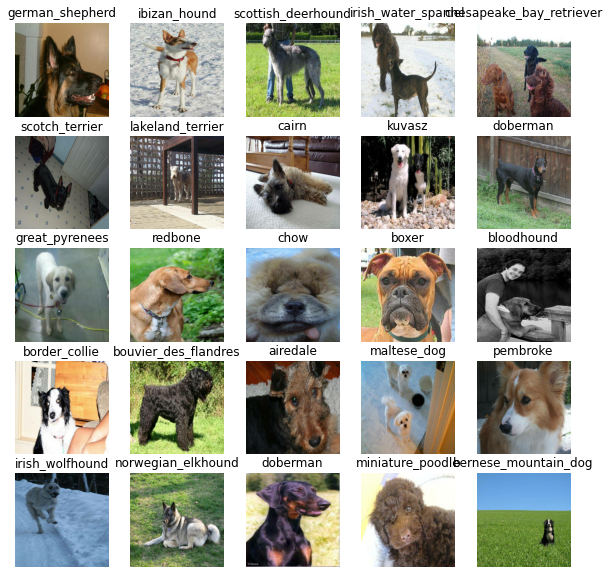

In [33]:
train_images, train_labels = next(train_data.as_numpy_iterator())    # unwinding the batch data 
show_25_images(train_images, train_labels)

In [34]:
# Visualizing out validation data
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

KeyboardInterrupt: ignored

## Building a model 
First lets define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use. (from tensorflow hub)

In [ ]:
# input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch , height , width , color channels

# output shape
OUTPUT_SHAPE = len(unique_breed)

# Setup model URL from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we define a function that takes our input shape, output shape and model url as parameters. We will use the Keras API (sequential) to create a model. 



In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url= MODEL_URL):
  print("Building model: ", MODEL_URL)

  # Setting up model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # input layer
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # output layer
  ])
  
  # Compiling the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  
  # Building the model
  model.build(INPUT_SHAPE)
  return model

In [ ]:
model = create_model()
model.summary()

## Creating callbacks

### TensorBoard Callback


TensorBoard helps provide a visual way to monitor the progress of your model during and after training.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

def create_tensorboard_callback():
  # Creating log directory for storing logs
  logdir = os.path.join("/content/drive/MyDrive/Dog-Vision/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)


### Early stopping callback
helps model from overfitting by stopping training if a certain metric stops increasing

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

## Training a model (on a subset of data)

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Creating a function which trains and returns a model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  model = create_model()

  tensorboard = create_tensorboard_callback()

  model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=valid_data, validation_freq=1, callbacks=[tensorboard, early_stopping])

  return model

In [ ]:
# Fit the model to the data
model = train_model()

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Dog-Vision/logs/20210810-140348

In [ ]:
predictions = model.predict(valid_data)
predictions

In [ ]:
predictions.shape

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breed[np.argmax(predictions[0])]}") # the predicted label

In [41]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of probabilities into label
  """
  return unique_breed[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[0])
pred_label

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image , label in valid_data.unbatch().as_numpy_iterator():
     images.append(image)
     labels.append(unique_breed[np.argmax(label)]) 
  return images, labels
val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]
    


Now we will create a function which will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction and ground truth label & prediction for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Pred Label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  plt.title("{} {:2.0f}% ({})".format(pred_label, np.max(pred_prob)*100,true_label), color=color)

In [ ]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=124)

Let's build a function to demonstrate. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using get_pred_label().
* Find the top 10:
    * Prediction probabilities indexes
    * Prediction probabilities values
    * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def pred_prob_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 prediction confidences
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Getting the predicted label
  pred_label = get_pred_label(pred_prob)

  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_pred_labels = unique_breed[top_10_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation="vertical")
  
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


In [ ]:
pred_prob_conf(prediction_probabilities=predictions, labels=val_labels, n=111)

In [ ]:
# Lets check a few predictions
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  pred_prob_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
# Creating a function to save model
def save_model(model, suffix=None):
  """
  Saves model to a directory
  """
  modeldir = os.path.join("/content/drive/MyDrive/Dog-Vision/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

  modelpath = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to .. {modelpath}")
  model.save(modelpath)
  return modelpath

In [ ]:
# Creating afunction to load a saved model
def load_model(model_path):
  """
  Takes the model directory as input and loads the model
  """
  print(f"loading model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(model, suffix="1000-images-Adam")

In [ ]:
# Evaluate the model
model.evaluate(valid_data)

## Training a model on full data 🐕

In [ ]:
len(X), len(y)

We've got over 10,000 images and label as data for our model to train on.

In [ ]:
# Create data batch with full data
full_data = create_data_batches(X,y)

In [ ]:
# Create model
full_model = create_model()

In [ ]:
# Create callbacks

full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Dog-Vision/logs

In [ ]:
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

In [ ]:
save_model(full_model, suffix="full_image_set_Adam")

## Making Predictions on Test dataset

In [ ]:
# Load test image filenames
test_path = "/content/drive/MyDrive/Dog-Vision/test/"
test_filenames1 = [test_path + fname for fname in os.listdir(test_path)]
test_filenames1[:10]

In [ ]:
len(test_filenames1)

In [ ]:
test_data1 = create_data_batches(test_filenames1, test_data=True)

In [ ]:
# Make prediction on test data
test_prediction1 = full_model.predict(test_data1, verbose=1)

In [ ]:
test_prediction1[0]

In [ ]:
len(test_prediction1[0])

##Preparing test dataset predictions for Kaggle

In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breed))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breed)] = test_prediction1
preds_df.head()


In [ ]:
# Saving prediction dataframe to csv for submission
# preds_df.to_csv("drive/My Drive/Dog-Vision/final_submission_mobilienetV2_adam.csv",
#                  index=False)

## Prediction on custom data

In [39]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Dog-Vision/models/20210814-07111628925118-full_image_set_Adam.h5",
                                          custom_objects={"KerasLayer": hub.KerasLayer})

In [36]:
# Custom data filepath
custom_data_path ="/content/drive/MyDrive/Dog-Vision/custom-data/"
custom_image_paths = [custom_data_path + path for path in os.listdir(custom_data_path)]

In [37]:
# Creating data batches
custom_batch = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches


In [43]:
# Get predictions from the model
custom_preds = loaded_model.predict(custom_batch)
custom_preds.shape

(2, 120)

In [47]:
# Find the prediction labels from the probabilities
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['german_shepherd', 'rottweiler']

In [49]:
# Unbatch custom images
custom_images = []
for images in custom_batch.unbatch().as_numpy_iterator():
  custom_images.append(images)


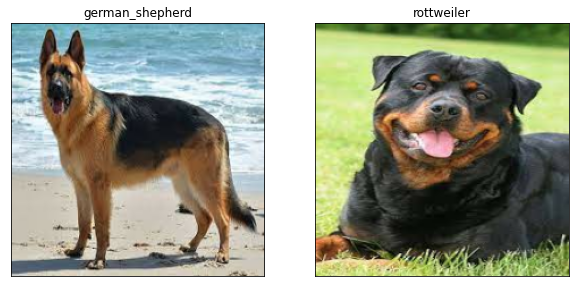

In [51]:
# Check custom predictions by plotting
plt.figure(figsize=(10,10))
for i,image in enumerate(custom_images):
  plt.subplot(1,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)